# ***Arya Rane***
### 23CHE1**57**

Problem Statement:
Solve the attached distillation example using programs created in last three sessions. \\
Design a (structured) packed bed distillation in stead of plate column.

Preliminary Design:
- Feed state: \\
Feed is 50% saturated liquid and 50% saturated vapor. $\implies q = 0.5$

- Feed rate:\\
$F = 300 + 2\times57 = 414\ \mathrm{kmol\,h^{-1}}$ \\
$x_f = 0.45$ \\
$x_D = 0.92,\quad x_B = 0.05$



In [ ]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import polars as pl
import numpy as np
import scipy.optimize as spopt
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
from typing import Dict
from dataclasses import dataclass

In [ ]:
F, x_f = (300 + 2 * 57) * (85.8) , 0.45
q = 0.5
alpha = 2.5
x_D = 0.92
x_B = 0.05

## Material Balance
Material Balance over all the streams and get flowrates and compositions

In [ ]:
def materialBalance(
    F: float, # Feed flow rate
    x_f: float, # Feed composition
    D: float = None, # Distillate flow rate
    x_D: float = None, # Distillate Composition
    B: float = None, # Bottoms flow rate

    x_B: float = None, # Bottoms Composition
    *,
    tol: float = 1e-8
)-> dict:

    keys    = ['D','x_D','B','x_B']
    values  = [D, x_D, B, x_B]
    known   = {k: (v is not None) for k, v in zip(keys, values)}
    n_known = sum(known.values())


    if not (2 <= n_known <= 4):
        raise ValueError("Must provide exactly two of D, x_D, B, x_B or both compositions x_D & x_B.")
    if known['D'] and known['B'] and not (known['x_D'] and known['x_B']):
        raise ValueError("Provide only one flow (D or B), not both, unless both compositions are given.")

    # Solve cases ...
    if known['D'] and known['x_D']:
        B_calc = F - D
        x_B_calc = (F * x_f - D * x_D) / B_calc
        result = {'D': D, 'x_D': x_D, 'B': B_calc, 'x_B': x_B_calc}
    elif known['B'] and known['x_B']:
        D_calc = F - B
        x_D_calc = (F * x_f - B * x_B) / D_calc
        result = {'D': D_calc, 'x_D': x_D_calc, 'B': B, 'x_B': x_B}
    elif known['x_D'] and known['x_B']:
        A = np.array([[1.0, 1.0], [x_D, x_B]])
        b = np.array([F, F * x_f])
        D_calc, B_calc = np.linalg.solve(A, b)
        result = {'D': D_calc, 'x_D': x_D, 'B': B_calc, 'x_B': x_B}
    else:
        if known['D'] and known['x_B']:
            B_calc = F - D
            x_D_calc = (F * x_f - B_calc * x_B) / D
            result = {'D': D, 'x_D': x_D_calc, 'B': B_calc, 'x_B': x_B}
        elif known['B'] and known['x_D']:
            D_calc = F - B
            x_B_calc = (F * x_f - D_calc * x_D) / B
            result = {'D': D_calc, 'x_D': x_D, 'B': B, 'x_B': x_B_calc}
        else:
            raise ValueError("Unsupported combination of inputs.")

    if result['D'] < -tol or result['B'] < -tol:
        raise ValueError(
            f"Unphysical negative flow: D={result['D']:.6f}, B={result['B']:.6f}."
        )

    return result


In [ ]:
matBal = materialBalance(F, x_f, x_D=x_D, x_B=x_B)
D   = matBal['D']
x_D = matBal['x_D']
B   = matBal['B']
x_B = matBal['x_B']
print(f"D={D:.5f}, x_D={x_D:.5f}, B={B:.5f}, x_B={x_B:.5f}")

D=16331.58621, x_D=0.92000, B=19189.61379, x_B=0.05000


## Pinch Point
Calculate the pinch point and get the minimum Reflux Ratio for infinite column with infinite stages.

In [ ]:
def intersections(
    q: float,
    x_f: float,
    alpha: float,
    x_D: float,
    param: float = 1.2,
    tol: float = 1e-10,
) -> dict:

    y_qline = lambda x: x * (q / (q - 1 + tol)) - x_f / (q - 1 + tol)
    y_equm  = lambda x: alpha * x / (1 + (alpha - 1) * x)

    xq, = fsolve(lambda x: y_qline(x) - y_equm(x), x0=0.5)
    yq = y_qline(xq)

    slope = lambda R: yq - ((R / (R + 1)) * xq + x_D / (R + 1))

    Rmin = fsolve(slope, x0=1.0)
    RR = Rmin * param

    top_line = lambda x: (RR * x) / (RR + 1) + x_D / (RR + 1)

    x_i, = fsolve(lambda x: top_line(x) - y_qline(x), x0=0.5)
    y_i = top_line(x_i)

    bottom_line = lambda y: (y - y_i) * (x_B - x_i) / (x_B-y_i) + x_i

    return {
        'xq': xq,
        'yq': yq,
        'Rmin': Rmin,
        'RR': RR,
        'x_i': x_i,
        'y_i': y_i,
    }

In [ ]:
intersections(q , x_f , alpha , x_D)
xq = intersections(q , x_f , alpha , x_D)['xq']
yq = intersections(q , x_f , alpha , x_D)['yq']
Rmin = intersections(q , x_f , alpha , x_D)['Rmin'][0]
RR = intersections(q , x_f , alpha , x_D)['RR'][0]
x_i = intersections(q , x_f , alpha , x_D)['x_i']
y_i = intersections(q , x_f , alpha , x_D)['y_i'][0]
xq,yq,Rmin,RR,x_i,y_i

(np.float64(0.33861107460526096),
 np.float64(0.5613889255070168),
 np.float64(1.609724993043089),
 np.float64(1.9316699916517068),
 np.float64(0.35335859691219057),
 np.float64(0.5466414031971377))

## Energy Balance

In [ ]:
@dataclass
class ColumnEnergyParams:
    F: float               # Feed flow rate (kg/hr)
    D: float               # Distillate flow rate (kg/hr)
    B: float               # Bottoms flow rate (kg/hr)
    q: float               # Thermal condition of feed (0: saturated vapor, 1: saturated liquid)
    alpha: float           # Relative volatility (for completeness)
    R: float               # Reflux ratio
    molwt_BT: float = 78.11 * x_f + (1-x_f) * 92.14 # MOlecular wt. of Composition of feed approximated everywhere (kg/kmol)

    # Constants
    c_p: float = 1.67e+5 / molwt_BT    # Liquid heat capacity (J/kg.K)
    lam_BT: float = 3.2e+7 / molwt_BT      # Latent heat of vaporization of MIxture (J/kg)
    c_p_w: float = 4186 # J/kg.K
    lam_w: float = 2.13e+6    # Latent heat of vaporization of Steam(J/kg)
    T_distill: float = 273.15 + 81.7 # Distillate temperature (K)
    T_feed: float = 273.15 + 94 # Feed temperature (K)
    T_boil: float = 273.15 + 94 # Boiling point of feed (K)
    T_reboil: float = 273.15 + 108  # Reboiler temp (K)
    T_cw_in: float = 27.8
    T_cw_out: float = 32.2        # Cooling water temperature rise (K)
    steam_cost: float = 3.31   # $/ton
    cw_cost: float = 0.0238    # $/ton

In [ ]:
def compute_energy(params: ColumnEnergyParams) -> pd.Series:
    # 1. Reflux and vapor flows
    L = params.R * params.D
    V = L + params.D        # Vapor flowrate from reboiler
    R = params.R
    B = params.B
    D = params.D
    F = params.F

    dT_cw = ((params.T_distill - params.T_cw_out)-(params.T_distill - params.T_cw_in)) / np.log((params.T_distill - params.T_cw_out)/(params.T_distill - params.T_cw_in))

    Vflow  = V + F * q      # kg/hr

    # Heat and Reboiler Energy and Power
    H_sens = F * params.c_p * (params.T_reboil - params.T_feed)  # J/hr

    H_feed = F * params.lam_BT * params.q  # J/hr

    H_latent = (Vflow - B) * params.lam_BT   # J/hr

    reboiler_duty = (H_sens + H_latent - H_feed + L * params.lam_BT) # Reboiler Duty J/hr

    m_s = reboiler_duty / params.lam_w  # Steam MAss Flow Rate kg/hr

    # Condenser Duty and Energy and Power
    condenser_duty = Vflow * params.lam_BT    # J/hr

    m_cw = condenser_duty / (params.c_p_w * dT_cw)    # Water mass flow rate kg/hr

    # Costs
    cost_steam = (m_s / 1000) * params.steam_cost  # $/hr
    cost_cw = (m_cw / 1000) * params.cw_cost   # $/hr

    return pd.Series({
        "Reflux flow (kg/hr)": L,
        "Vapor flow (kg/hr)": V,
        "Feed flow (kg/hr)": F,
        "Bottoms flow (kg/hr)": B,
        "Distillate flow (kg/hr)": D,
        "Reflux": R,
        "Boilup rate (kg/hr)": Vflow - B,
        "Vapour Flow Rate (kg/hr)": Vflow,
        "Steam flow (kg/hr)": m_s,
        "Cooling water flow (kg/hr)": m_cw,
        "Reboiler Duty (kW)": reboiler_duty/3600000,
        "Condenser duty (kW)": condenser_duty/3600000,
        "Steam cost ($/hr)": cost_steam,
        "CW cost ($/hr)": cost_cw
    })

In [ ]:
params = ColumnEnergyParams(F=F, D=D, B=B, R=RR, q=q, alpha=alpha)
energy = compute_energy(params)
print(energy)

Reflux flow (kg/hr)           31547.234992
Vapor flow (kg/hr)            47878.821199
Feed flow (kg/hr)             35521.200000
Bottoms flow (kg/hr)          19189.613793
Distillate flow (kg/hr)       16331.586207
Reflux                            1.931670
Boilup rate (kg/hr)           46449.807406
Vapour Flow Rate (kg/hr)      65639.421199
Steam flow (kg/hr)            10998.358011
Cooling water flow (kg/hr)    17997.735434
Reboiler Duty (kW)             6507.361823
Condenser duty (kW)            6798.151174
Steam cost ($/hr)                36.404565
CW cost ($/hr)                    0.428346
dtype: float64


## Calculate Number of Stages

In [ ]:
def stages(
    x_B: float,
    x_D: float,
    alpha: float,
    x_i: float,
    y_i: float
) -> tuple:
    y_equm  = lambda x: alpha * x / (1 + (alpha - 1) * x)
    top_line = lambda y: (y - y_i) * (x_D - x_i) / (x_D - y_i) + x_i
    bottom_line = lambda y: (y - y_i) * (x_B - x_i) / (x_B - y_i) + x_i

    x, y = x_B, x_B
    xs, ys = [x], [y]
    total = rect = strip = 0

    while x < x_D:
        y = float(y_equm(x))
        ys.append(y)
        xs.append(x)
        if y < y_i:
            x = float(bottom_line(y))
            ys.append(y)
            strip += 1
        else:
            if y > x_D:
                x = y
                ys.append(y)
                rect += 1
            else:
                x = float(top_line(y))
                ys.append(y)
                rect += 1
        xs.append(x)

        total += 1

    return pd.Series({ "xs":xs, "ys" :ys, "total":total, "rect":rect, "strip":strip})

In [ ]:
xs, ys, total, rect, strip = stages(x_B, x_D, alpha, x_i, y_i)
total, rect, strip

(13, 7, 6)

In [ ]:
Nstages = stages(x_B, x_D, alpha, x_i, y_i)

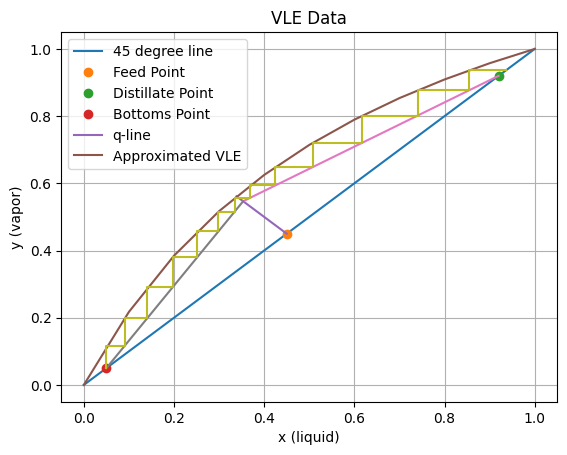

In [ ]:
plt.plot([0,1], [0,1], label='45 degree line')
plt.plot(x_f, x_f, 'o', label='Feed Point')
plt.plot(x_D, x_D, 'o', label='Distillate Point')
plt.plot(x_B, x_B, 'o', label='Bottoms Point')
plt.plot([x_f,xq],[x_f,yq], label='q-line')
x = np.linspace(0,1,11)
y = (alpha*x)/(1+(alpha-1)*x)
plt.plot(x, y, label='Approximated VLE')

plt.xlabel('x (liquid)')
plt.ylabel('y (vapor)')
plt.title('VLE Data')
plt.legend()
plt.grid(True)

plt.plot([x_D,x_i],[x_D,y_i])
plt.plot([x_B,x_i],[x_B,y_i])

plt.plot(xs,ys)

In [ ]:
hetp = pd.read_csv("hetp.csv",
                   sep=r"\s+", header=None, names=["F","HETP"])
dpdz = pd.read_csv("dpdz.csv",
                   sep=r"\s+", header=None, names=["F","dpdz"])

hetp["F"] = hetp["F"].str.replace(",", "").astype(float)
dpdz["F"] = dpdz["F"].str.replace(",", "").astype(float)
hetp["HETP"] = hetp["HETP"].astype(float)
dpdz["dpdz"] = dpdz["dpdz"].astype(float)
hetp.sort_values("F", inplace=True)
dpdz.sort_values("F", inplace=True)
hetp.reset_index(drop=True, inplace=True)

In [ ]:
f_F = interp1d(dpdz["dpdz"],dpdz["F"], kind="linear", fill_value="extrapolate")
f_hetp = interp1d(hetp["F"], hetp["HETP"], kind="linear", fill_value="extrapolate")

In [ ]:
x_min = min(dpdz["F"].min(), hetp["F"].min())
x_max = max(dpdz["F"].max(), hetp["F"].max())
x_dense = np.linspace(x_min, x_max, 200)

y_dpdz_dense = f_F(x_dense)
y_hetp_dense = f_hetp(x_dense)

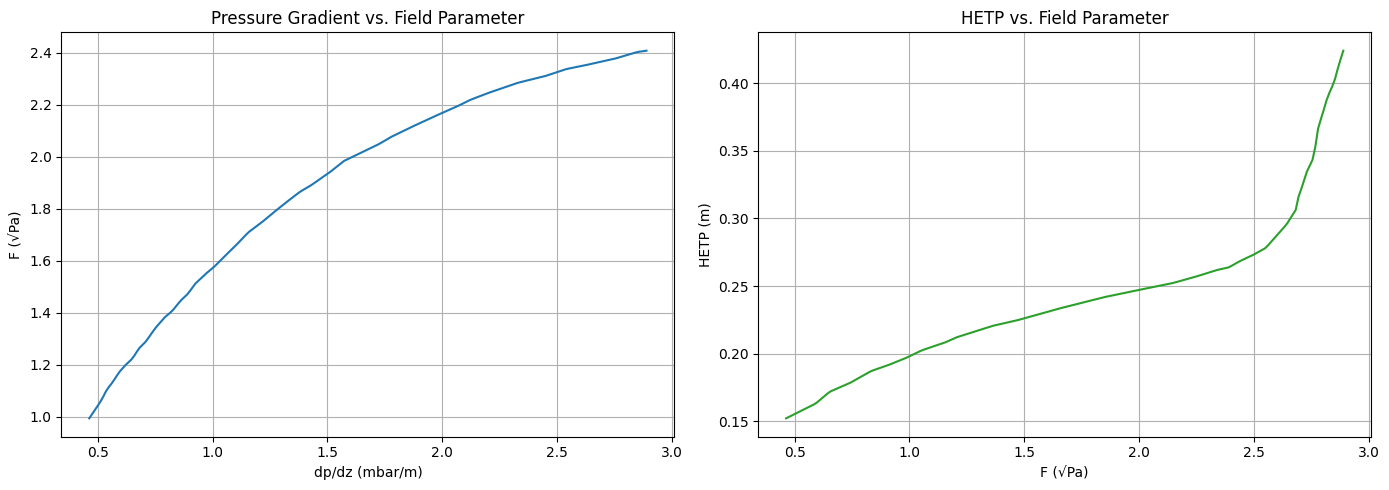

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# dp/dz vs F
axs[0].plot(x_dense, y_dpdz_dense, color='tab:blue')
axs[0].set_ylabel("F (Pa)")
axs[0].set_xlabel("dp/dz (mbar/m)")
axs[0].set_title("Pressure Gradient vs. Field Parameter")
axs[0].grid(True)

# HETP vs F
axs[1].plot(x_dense, y_hetp_dense, color='tab:green')
axs[1].set_xlabel("F (Pa)")
axs[1].set_ylabel("HETP (m)")
axs[1].set_title("HETP vs. Field Parameter")
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
def area(
        vmax: float = 0.76,
        param: float = 1.5,
        mol_wt: float = 85.5,
        ):
    params = ColumnEnergyParams(F=F, D=D, B=B, R=RR, q=q, alpha=alpha)
    Vflow = compute_energy(params)["Vapour Flow Rate (kg/hr)"]
    M      = 85.8e-3                                     # kg/mol
    rho_V  = 96000 * M / (8.314 * (108 + 273.15))        # kg/m³
    V_Q    = Vflow / (rho_V * 3600)
    Area      = V_Q / (0.9*vmax)                         # m²
    Dia      = np.sqrt(4*Area/np.pi)                     # m
    return Area, Dia

In [ ]:
Area , Diameter = area()
Area , Diameter

(np.float64(10.255422658765125), np.float64(3.6135314689528832))

In [ ]:
def height(Nstages, f_F, f_hetp):
    dpdz = 0.5
    F = f_F(dpdz)
    hetp = f_hetp(F)
    height = hetp * Nstages["total"] * 1.2 / 0.7
    return height
Height = height(Nstages, f_F, f_hetp)
Height

np.float64(4.493929581028436)

In [ ]:
def pack_costs(
    Height , Area,
    cost = 2000 # $/m3
):
    packVol = Height * Area
    return packVol * cost

In [ ]:
p_costs = pack_costs(Height,Area)
p_costs

np.float64(92174.29450434777)

In [ ]:
def shell_costs(
    Height , Diameter,
    cost = (450 / 85)  # $/kg
):
    thickness = 0.004
    shell = Height * (Diameter + 2*thickness)
    shell_vol = Height * np.pi * Diameter * thickness
    m_SS316 = shell_vol * 8000
    cost_SS = m_SS316 * cost
    costs = cost_SS * 0.4 # fabrication = 40% of metal costs
    return costs

In [ ]:
s_costs = shell_costs(Height, Diameter)
s_costs

np.float64(3457.0967546108022)

In [ ]:
def miscellaneous(pack_costs, shell_costs):
    return ((pack_costs + shell_costs) * 0.2) # Transportatio and miscellaneous cost $40% of fabrication and material costs

In [ ]:
miscellaneous(p_costs, s_costs)

np.float64(19126.278251791715)

## Condenser Sizing

In [ ]:
def condenser_cost(energy,
    T_top: float = 273.15 + 81.7,
    T_cw_in: float = 273.15 + 27.8,
    T_cw_out: float = 273.15 + .2,
    U: float = 600.0, # kJ/(hr.m2.K)
    c_p_w: float = 4186, # J/kg.K
    cost_m2: float = 230  # $/m2
) -> Dict[str, float]:

    LMTD = ((params.T_distill - params.T_cw_out)-(params.T_distill - params.T_cw_in)) / np.log((params.T_distill - params.T_cw_out)/(params.T_distill - params.T_cw_in))

    # 3. Required area (m²)
    A_m2 = energy["Condenser duty (kW)"] * 3600 / (U * LMTD)

    cost_A = A_m2 * cost_m2
    return cost_A

In [ ]:
condenser_costs = condenser_cost(energy)
condenser_costs

np.float64(28879.7662019678)

## Reboiler Sizing - Falling Film Evaporator

In [ ]:
def reboiler_cost(
        energy,
        cost_m2 = 200 # $/m2
):
    Q_R = energy["Reboiler Duty (kW)"] * 3600 / 4.184 # kcal/hr
    FFE_Heat_Duty = 6000 # kcal/m2.hr (Considering LMTD 25 C)
    FFE_Area = Q_R / FFE_Heat_Duty
    Tube_OD = 0.04 # m
    Tube_thk = 0.0012
    Tube_ID = Tube_OD - 2*Tube_thk
    Tube_perimeter = np.pi * Tube_ID * 100
    Wetting_Area = 10 # lt/cm.hr
    Flow_Single_Tube = Wetting_Area/Tube_perimeter
    Tube_length = 3
    Single_Tube_HT_Area = np.pi*Tube_OD*Tube_length # m2
    N_Tubes = FFE_Area/Single_Tube_HT_Area
    Total_Recirculation_Liquid_Flow = N_Tubes * Flow_Single_Tube
    costs = FFE_Area * cost_m2
    return costs


In [ ]:
reboiler_cost(energy)

np.float64(186635.61634948425)

# __Total Costing__

### MEBC and basic Thermodynamics
`matBal = materialBalance(F, x_f, x_D=x_D, x_B=x_B)` \\

`inter = intersections(q , x_f , alpha , x_D)` \\

`params = ColumnEnergyParams(F=F, D=D, B=B, R=RR, q=q, alpha=alpha)` # Class \\

\\
### Operational Costs
`energy = compute_energy(params)` \\

\\
### Column Specifications and Design

`Nstages = stages(x_B, x_D, alpha, x_i, y_i)` \\

`Area , Diameter = area()` \\

`Height = height()` \\
 \\
### Capital Costs

`pack_costs = pack_costs(Height,Area)` \\

`shell_costs = shell_costs(Height, Diameter)` \\

`miscellaneous(pack_costs, shell_costs)` \\

`condenser_costs = condenser_cost(energy)["Costs"]` \\

`reboiler_cost(energy)`





In [ ]:
def total_costs(
    f_F, f_hetp,
    F: float = F, # Feed flow rate
    x_f: float = x_f, # Feed composition
    D: float = None, # Distillate flow rate
    x_D: float = None, # Distillate Composition
    B: float = None, # Bottoms flow rate

    x_B: float = None, # Bottoms Composition
    q: float = None, # Thermal condition of feed (0: saturated vapor, 1: saturated liquid)
    alpha: float = None, # Relative volatility (for completeness)
    param: float = None,

)-> dict:
    matBal = materialBalance(F, x_f, x_D=x_D, x_B=x_B)
    D = matBal['D']
    x_D = matBal['x_D']
    B = matBal['B']
    x_B = matBal['x_B']

    inter = intersections(q , x_f , alpha , x_D, param = param)
    x_i = inter['x_i']
    y_i = inter['y_i'][0]
    RR = inter['RR']

    params = ColumnEnergyParams(F=F, D=D, B=B, R=RR, q=q, alpha=alpha)

    energy = compute_energy(params)

    Nstages = stages(x_B, x_D, alpha, x_i, y_i)



    Area , Diameter = area()

    Height = height(Nstages,f_F, f_hetp)

    p_costs = pack_costs(Height,Area)

    s_costs = shell_costs(Height, Diameter)

    cond_costs = condenser_cost(energy)

    re_costs = reboiler_cost(energy)

    operational_costs = (
        energy["Steam cost ($/hr)"].sum() +
        energy["CW cost ($/hr)"].sum()
    )

    capital_costs = (
        p_costs +
        s_costs +
        miscellaneous(p_costs, s_costs) +
        cond_costs +
        re_costs
    )

    return {
        'total_costs': (capital_costs + operational_costs * 8500)[0],
        'operational_costs': operational_costs,
        'capital_costs': capital_costs[0]
    }

In [ ]:
res = total_costs(f_F , f_hetp , x_D = x_D, x_B = x_B, q = q, alpha = alpha, param = 1.2)
print(res['total_costs'], res['operational_costs'], res['capital_costs'])


643352.7965899953 36.83291112091682 330273.05206220236


In [ ]:
# 1. Build the param list
param_values = list(np.arange(1.001, 1.11, 0.005)) + \
               list(np.arange(1.11, 1.5, 0.05))

# 2. Loop, call total_costs and store results
rows = []
for p in param_values:
    res = total_costs(f_F , f_hetp , x_D = x_D, x_B = x_B, q = q, alpha = alpha, param = p)
    rows.append({
        'param': p,
        'total_costs': res['total_costs'],
        'operational_costs': res['operational_costs'],
        'capital_costs': res['capital_costs'],
    })

# 3. Create DataFrame
df = pd.DataFrame(rows)

In [ ]:
df

,param,total_costs,operational_costs,capital_costs
0,1.001,734701.390338,30.736434,473441.702283
1,1.006,675049.544466,30.889612,412487.844942
2,1.011,659535.263790,31.042790,395671.552797
3,1.016,644020.983115,31.195967,378855.260652
4,1.021,637334.215478,31.349145,370866.481547
5,1.026,639474.960881,31.502323,371705.215480
6,1.031,632788.193245,31.655501,363716.436375
7,1.036,626101.425609,31.808679,355727.657269
8,1.041,628242.171012,31.961856,356566.391203
9,1.046,621555.403375,32.115034,348577.612098


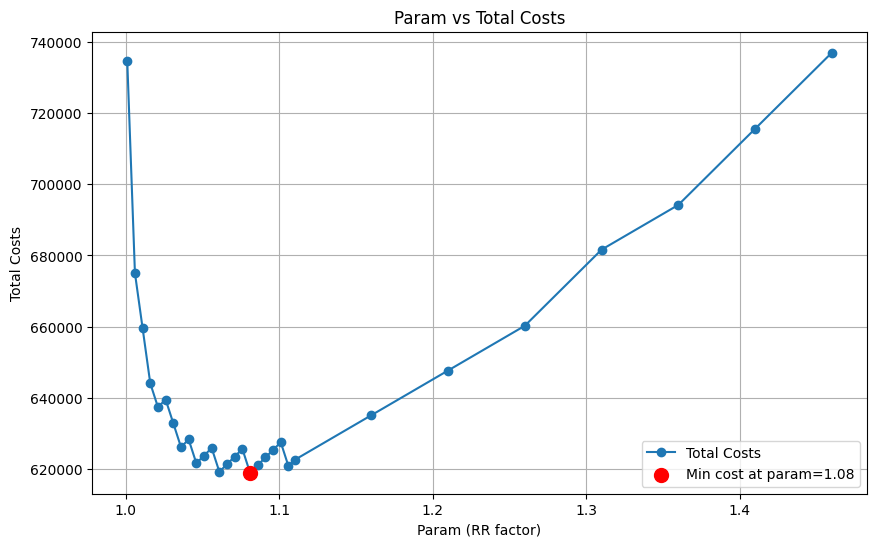

Minimum total cost = 618885.60 at param = 1.0809999999999982


In [ ]:
idx_min = df['total_costs'].idxmin()
best_param = df.loc[idx_min, 'param']
best_cost = df.loc[idx_min, 'total_costs']

plt.figure(figsize=(10,6))
plt.plot(df['param'], df['total_costs'], marker='o', label='Total Costs')
plt.scatter(best_param, best_cost, color='red', s=100, zorder=5,
            label=f'Min cost at param={best_param:.2f}')

plt.xlabel('Param (RR factor)')
plt.ylabel('Total Costs')
plt.title('Param vs Total Costs')
plt.legend()
plt.grid(True)
plt.show()

print(f"Minimum total cost = {best_cost:.2f} at param = {best_param}")